In [ ]:
# loading the libraries
!pip install bert-tensorflow
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 KB 3.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 90.1 MB/s eta 0:00:00


In [ ]:
# connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importing libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import tqdm

# specify GPU
device = torch.device("cuda")

In [ ]:
# importing the data
phishing_emails = pd.read_csv("/content/drive/My Drive/thesis/phishing_emails.csv")
ham_emails = pd.read_csv("/content/drive/My Drive/thesis/ham_emails.csv")


In [ ]:
# downloading libraries
!pip install torchtext==0.8.0 pytorch-lightning==1.2.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 816.5/816.5 KB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 KB 41.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492036 sha256=9883c8303aa855354966b17d2cf5c24a76defae7af668ab9054537bc1ea7d646
  Stored in directory: /root/.cache/pip/wheels/a0/0b/ee/e6994fadb42c1354dcccb139b0bf2795271bddfe6253ccdf11
Successfully built future
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.14.0
    Uninstalling torchtext-0.14.0:
      Successfully uninstalled torchtext-0.14.0


In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
pl.seed_everything(RANDOM_SEED)

OSError: ignored

In [ ]:
# 6th Cell will give an error on the first try, run cell 5 and try cell 6 again. This time it will work

In [ ]:
# importing bert
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# sample data
text = ["this is a good day", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 2204, 2154, 102, 0, 0, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
#importing goEmotions data
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv

--2023-01-17 19:31:49--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14174600 (14M) [application/octet-stream]
Saving to: ‘data/full_dataset/goemotions_1.csv’

goemotions_1.csv    100%[===================>]  13.52M  68.1MB/s    in 0.2s    

2023-01-17 19:31:49 (68.1 MB/s) - ‘data/full_dataset/goemotions_1.csv’ saved [14174600/14174600]

--2023-01-17 19:31:50--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.128|:443... connected.
HTTP request sent, awaiting r

In [ ]:
# loading go emotions data to CSV
goem_1 = pd.read_csv("/content/data/full_dataset/goemotions_1.csv")
goem_2 = pd.read_csv("/content/data/full_dataset/goemotions_2.csv")
goem_3 = pd.read_csv("/content/data/full_dataset/goemotions_3.csv")

In [ ]:
# concatenating the data 
goem_all = pd.concat([goem_1, goem_2, goem_3])
goem_all.shape

(211225, 37)

In [ ]:
# excluding the unclear data
goem_all = goem_all.loc[goem_all['example_very_unclear']==False]
goem_all.shape

(207814, 37)

In [ ]:
# making train/test split
train_df, val_df = train_test_split(goem_all, test_size=0.2)
train_df.shape, val_df.shape

((166251, 37), (41563, 37))

In [ ]:
# importing colors for graphics
import random
import matplotlib.colors as mcolors
colors = random.choices(list(mcolors.CSS4_COLORS.values()),k = 27)

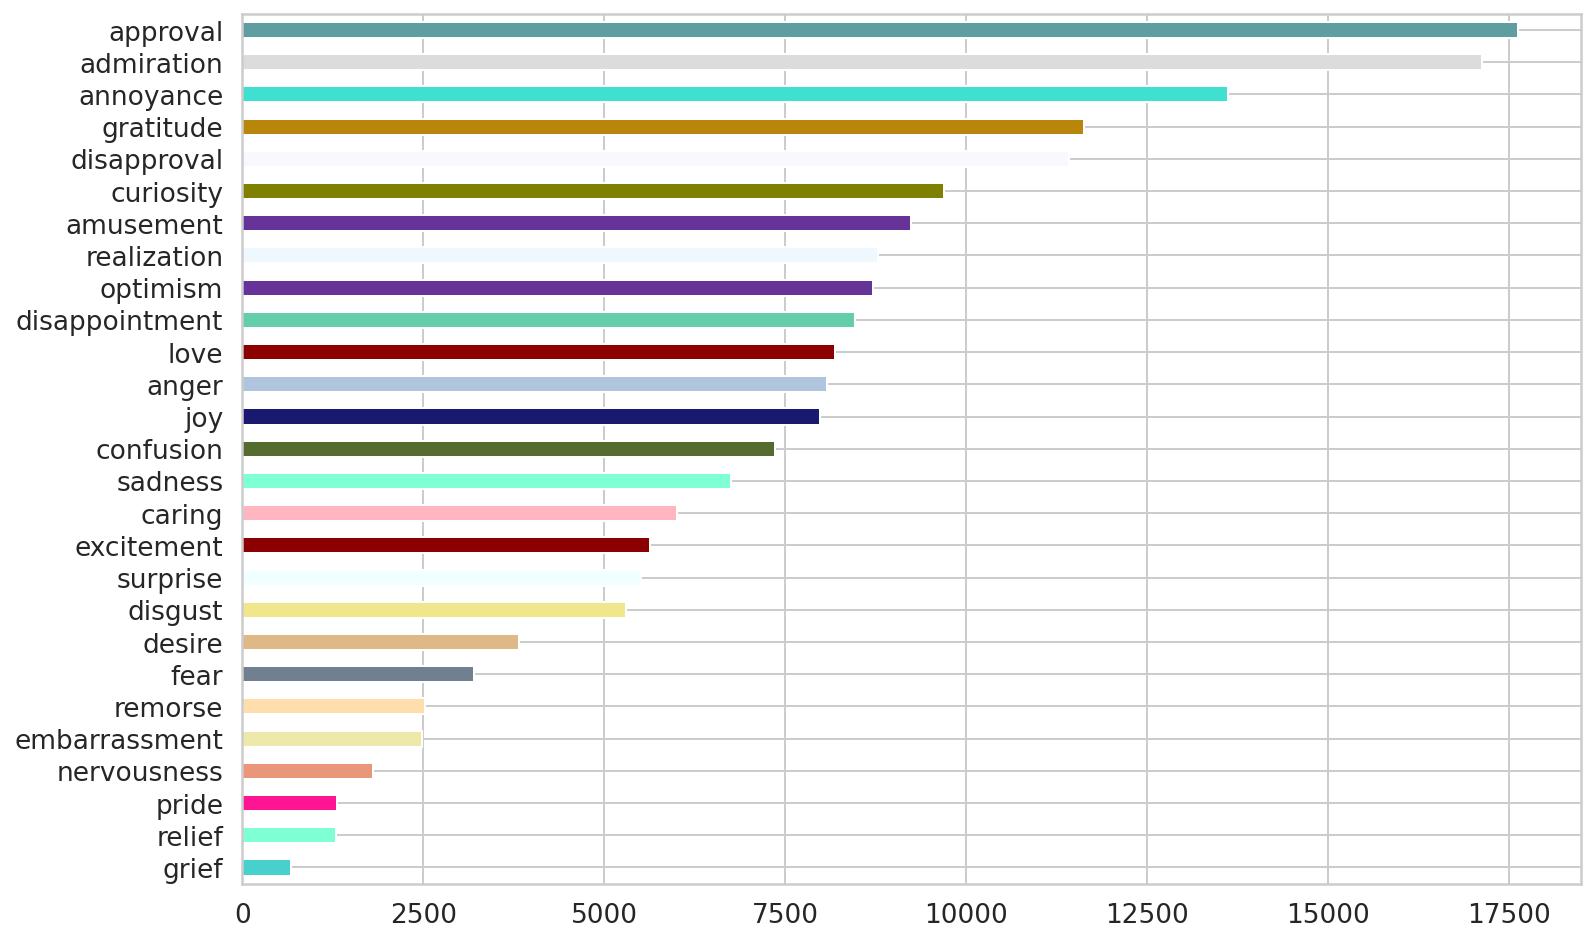

In [ ]:
# data distribution by label
LABEL_COLUMNS = goem_all.columns.tolist()[9:]
goem_all[LABEL_COLUMNS[:-1]].sum().sort_values().plot(kind="barh", color = colors );

In [ ]:
# downsampling the data for more balanced training dataset
train_df = pd.concat([
  goem_all[goem_all['neutral']==1].sample(10000),
  goem_all[goem_all['approval']==1].sample(6000),
  goem_all[goem_all['admiration']==1].sample(6000),
  goem_all[goem_all['annoyance']==1].sample(8000),
  goem_all[goem_all['gratitude']==1].sample(9000),
  goem_all[goem_all['disapproval']==1].sample(10000),
  goem_all[goem_all['curiosity']==1],
  goem_all[goem_all['amusement']==1],
  goem_all[goem_all['realization']==1],
  goem_all[goem_all['optimism']==1],
  goem_all[goem_all['disappointment']==1],
  goem_all[goem_all['love']==1],
  goem_all[goem_all['anger']==1],
  goem_all[goem_all['joy']==1],
  goem_all[goem_all['confusion']==1],
  goem_all[goem_all['sadness']==1],
  goem_all[goem_all['caring']==1],
  goem_all[goem_all['excitement']==1],
  goem_all[goem_all['surprise']==1],
  goem_all[goem_all['disgust']==1],
  goem_all[goem_all['desire']==1],
  goem_all[goem_all['fear']==1],
  goem_all[goem_all['remorse']==1],
  goem_all[goem_all['embarrassment']==1],
  goem_all[goem_all['nervousness']==1],
  goem_all[goem_all['pride']==1],
])
train_df = train_df.drop_duplicates()

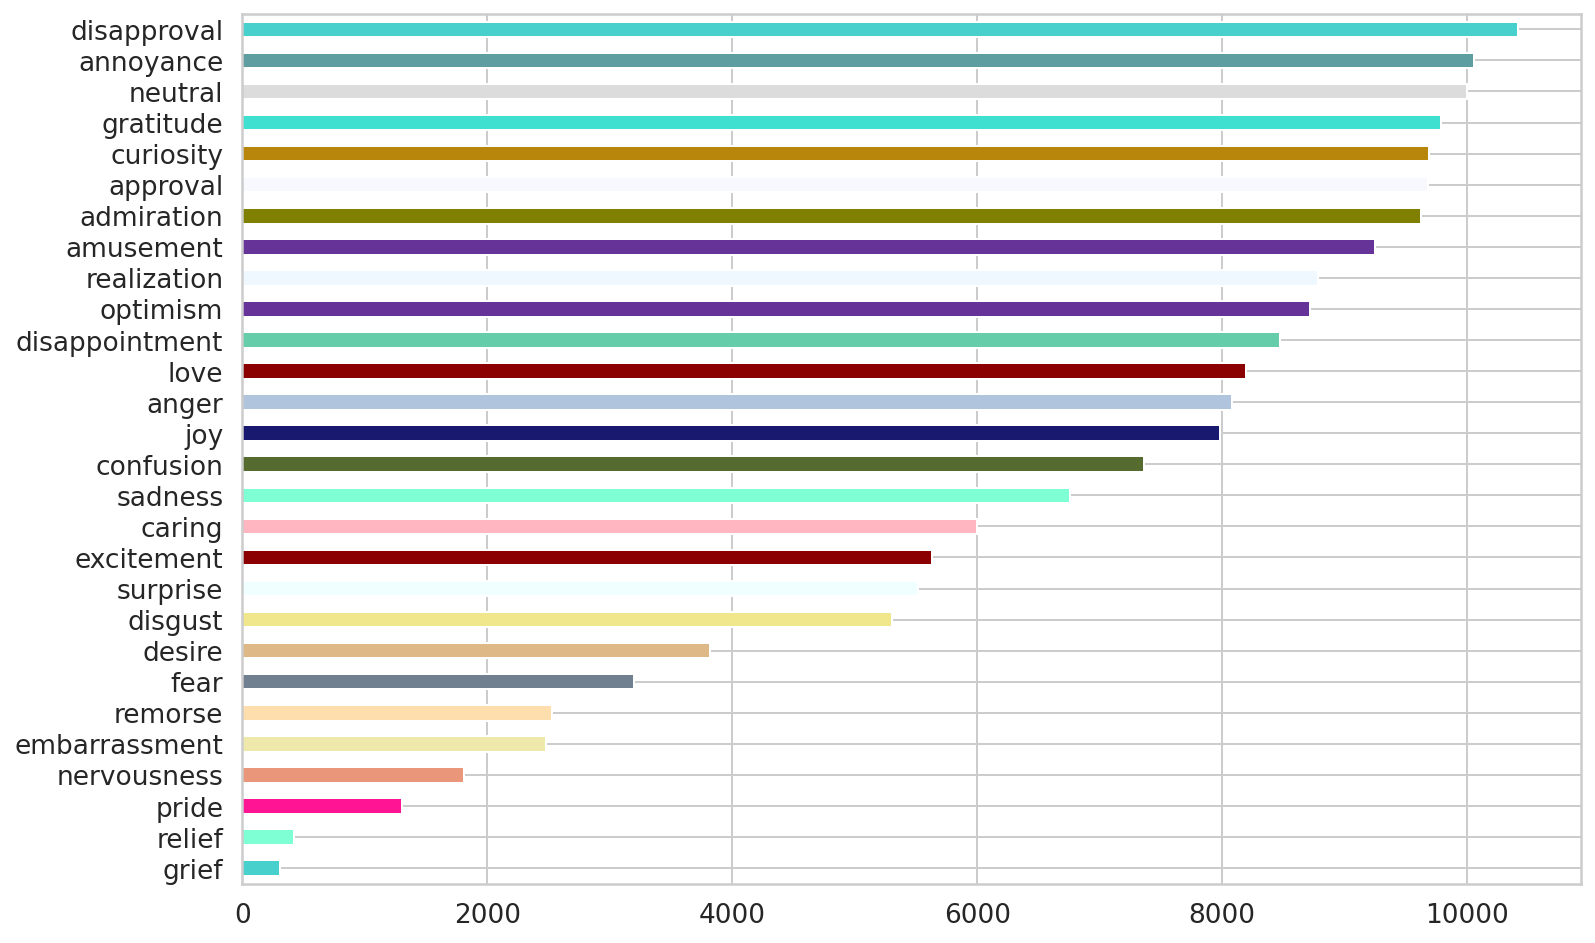

In [ ]:
# printing the downsampled data
LABEL_COLUMNS = goem_all.columns.tolist()[9:]
train_df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh", color = colors);

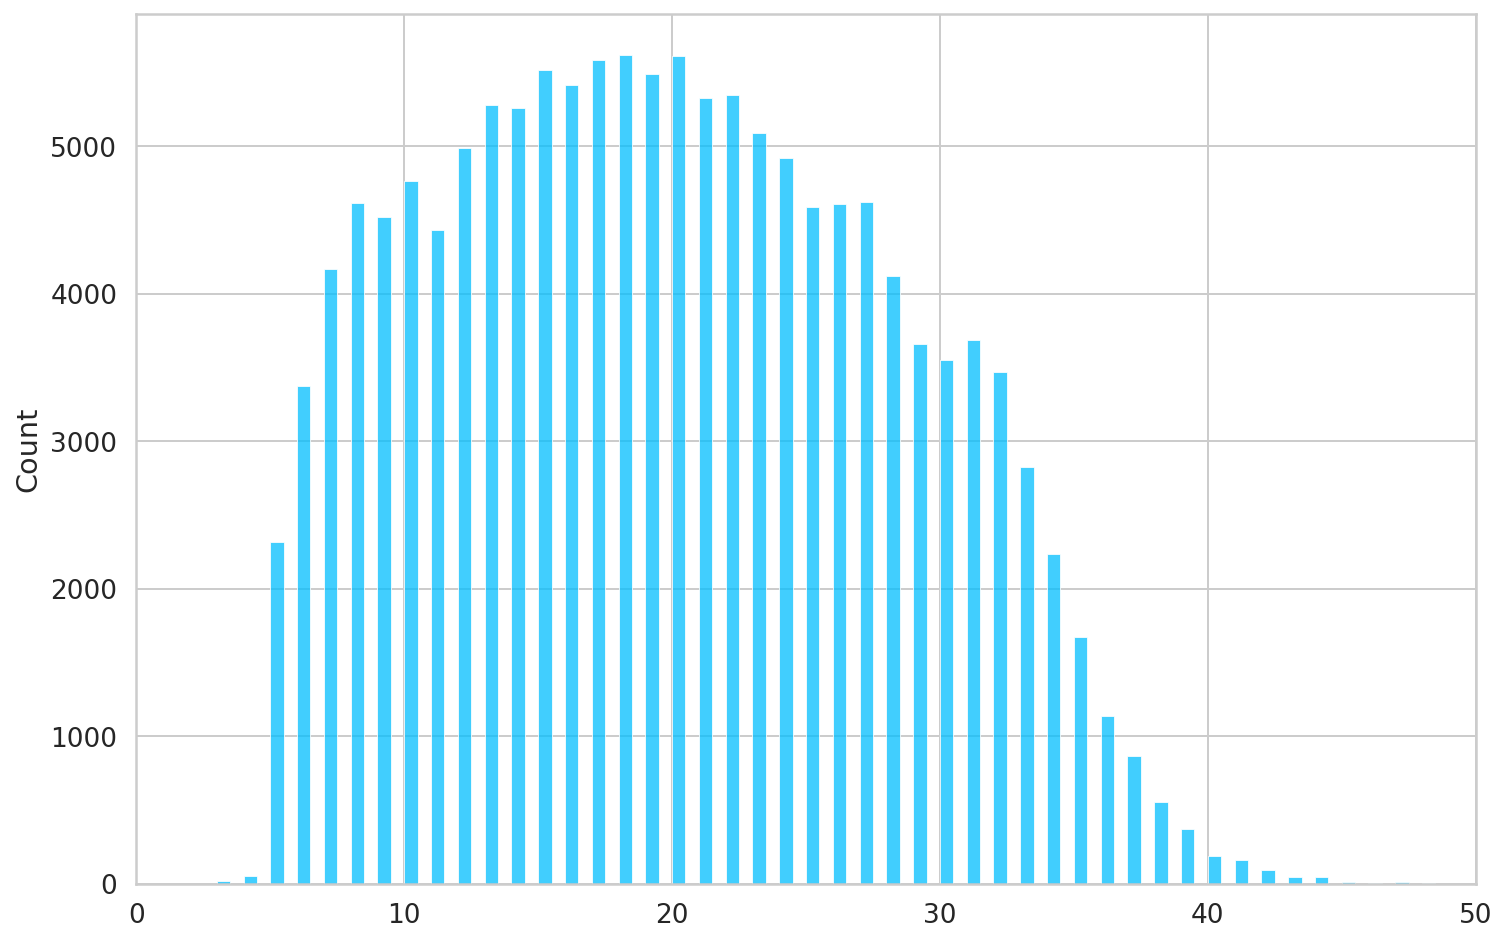

In [ ]:
# checking token counts of the data
token_counts = []
for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["text"],
    max_length=512,
    truncation=True
  ))
  token_counts.append(token_count)
sns.histplot(token_counts)
plt.xlim([0, 50]);

In [ ]:
# assing a token count
MAX_TOKEN_COUNT = 32

In [ ]:
# This code defines a custom dataset class called EmailsDataset that inherits from PyTorch's Dataset class. 
# The class is used to load and pre-process the email dataset for training a model.
class EmailsDataset(Dataset):
  # This is the constructor method and it takes three parameters: data, tokenizer, and max_token_len. 
  # The data parameter is a Pandas DataFrame that contains the email data, tokenizer is an instance of BertTokenizerFast 
  # which is used to tokenize the text, and max_token_len is an integer that sets the maximum length of the tokenized text.
  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: BertTokenizerFast,
    max_token_len: int = 32
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len

  # Function to get length
  def __len__(self):
    return len(self.data)

  # This method is used to get a single item from the dataset at a given index. 
  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]
    comment_text = data_row.text
    labels = data_row[LABEL_COLUMNS]
    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [ ]:
# loading train data into dataset class
train_dataset = EmailsDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

# creating sample item
sample_item = train_dataset[0]
#checking the keys of the item
sample_item.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [ ]:
# instead of changing name, created another one. This line doesn't do anything but createing the bert model object with different name
bert_model = bert

# Creating sample batch for testing and checking it's shape
sample_batch = next(iter(DataLoader(train_dataset, batch_size=128, num_workers=2)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([128, 32]), torch.Size([128, 32]))

In [ ]:
# feeding the bert model with sample batch 
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])
output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([128, 32, 768]), torch.Size([128, 768]))

In [ ]:

# Data module for Emails with pytorch lightning library
# used for handling and loading data for email classification task with Pytorch Lightning library.
class EmailsDataModule(pl.LightningDataModule):
  # The class is initialized with the train and test dataframe, tokenizer, batch size and max token length. The super class is also initialized.
  def __init__(self, train_df, test_df, tokenizer, batch_size=64, max_token_len=50):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  # This function is used for setting up the train and test dataset by creating instances of EmailsDataset class.
  def setup(self, stage=None):
    self.train_dataset = EmailsDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )
    self.test_dataset = EmailsDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )
  # This function is used for loading the train dataset and returns a Pytorch DataLoader instance with batch size, 
  # shuffle and number of workers set as per the class variables.
  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  # This function is used for loading the validation dataset and returns a Pytorch DataLoader instance 
  # with batch size and number of workers set as per the class variables.
  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

   # This function is used for loading the test dataset and returns a Pytorch DataLoader instance 
   # with batch size and number of workers set as per the class variables. 
  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [ ]:
# setting the number of epochs
N_EPOCHS = 3

# setting the batch size
BATCH_SIZE = 12

# creating our data module
data_module = EmailsDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

In [ ]:
# this class is used for training a model for tagging emails with a certain label using Pytorch Lightning library.
class EmailsTagger(pl.LightningModule):

  # initializes the class with number of classes, number of training steps, and number of warmup steps. 
  # It also initializes the BERT model, a linear classifier, and a criterion for loss calculation.
  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = bert_model
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()

  # Defines the forward pass of the model. 
  # It takes input_ids, attention_mask, and labels as input. 
  # It passes the input through BERT model, applies linear classifier on the pooled output and sigmoid function on the output to get the final output.
  # Also, it calculates the loss if labels are provided.
  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output


  # Defines the training step. 
  # It takes a batch of data, and applies the forward pass on the data, logs the train loss, and returns the loss, predictions, and labels.
  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  # Defines the validation step. 
  # It takes a batch of data, and applies the forward pass on the data, logs the validation loss, and returns the loss.
  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss


  # Defines the test step. 
  # It takes a batch of data, and applies the forward pass on the data, logs the test loss, and returns the loss.
  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  # Defines the end of training epoch. 
  # It takes outputs from the training step, and calculates the roc-auc score for each class and logs it.
  def training_epoch_end(self, outputs):
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)
    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)


  # Defines the optimizer and learning rate scheduler to be used during training. 
  # It uses AdamW optimizer and linear schedule with warmup.    
  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )
    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


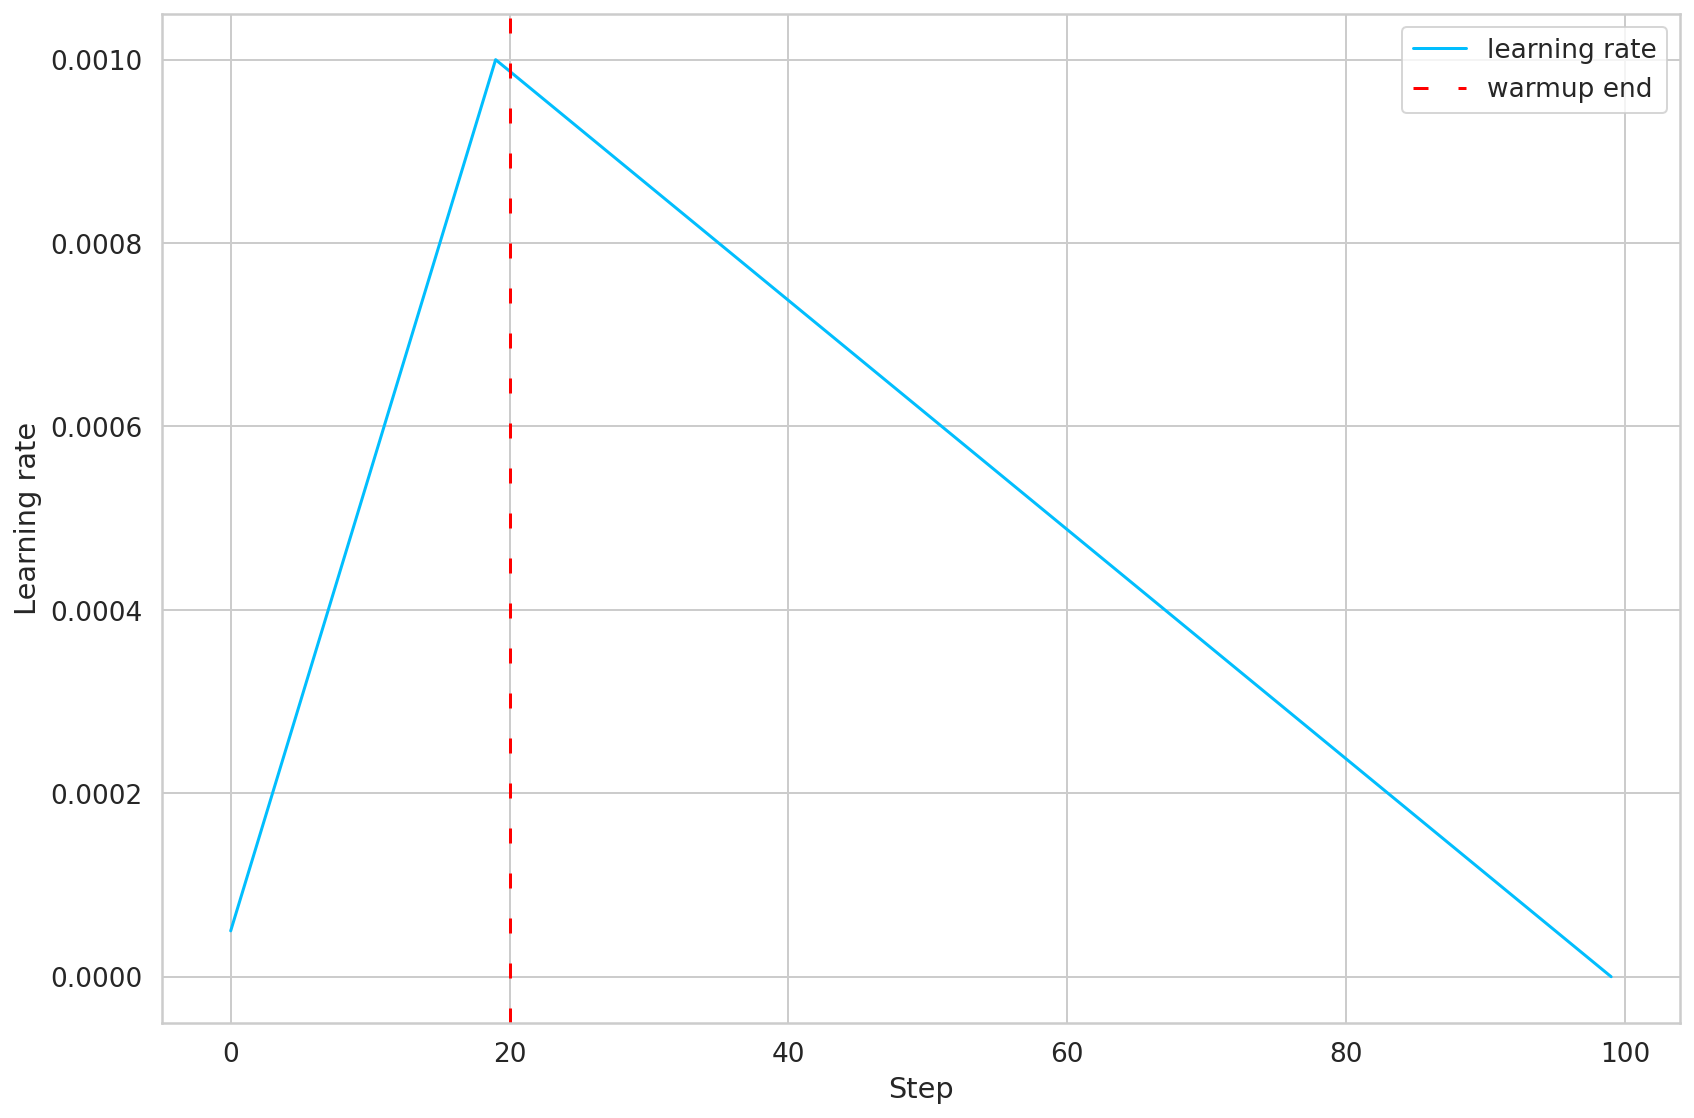

In [ ]:
# This code creates a dummy linear model with 2 inputs and 1 output, 
# an AdamW optimizer with a learning rate of 0.001, 
# a warmup schedule for 20 steps, and a total training steps of 100.

# The optimizer and scheduler are defined, 
# then a for loop is used to iterate over the total number of training steps, 
# at each step the optimizer step() and scheduler step() are called. 
# The current learning rate is appended to the learning_rate_history list.

# At the end, a plot is created that shows the learning rate over time, 
# including a vertical line indicating the end of the warmup period. 
# The plot includes labels for the x and y axis and a legend. 
# The plt.tight_layout() is used to make sure that the plot looks good.

# This code will show the learning rate change over time, 
# the red line indicates the end of the warmup period and the change of learning rate after that.

dummy_model = nn.Linear(2, 1)
optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)
warmup_steps = 20
total_training_steps = 100
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)
learning_rate_history = []
for step in range(total_training_steps):
  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

In [ ]:
# This code calculates the number of steps per epoch and the total number of training steps.

steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [ ]:
# This code calculates the number of warmup steps and the total number of training steps.
# This information is used in the definition of the learning rate scheduler to schedule the learning rate over the course of the training process, 
# where the learning rate starts at a low value and increases to the final value over the course of the warmup period

warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps


(7014, 35070)

In [ ]:
# This code creates an instance of the EmailsTagger class, 
# passing in the number of classes, warmup steps, and total training steps as arguments.

model = EmailsTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

In [ ]:
criterion = nn.BCELoss()


prediction = torch.FloatTensor(
  [10.95873564, 1.07321467, 1.58524066, 0.03839076, 15.72987556, 1.09513213]
)
labels = torch.FloatTensor(
  [1., 0., 0., 0., 1., 0.]
)

torch.sigmoid(prediction)
criterion(torch.sigmoid(prediction), labels)
_, predictions = model(sample_batch["input_ids"], sample_batch["attention_mask"])
predictions

In [ ]:
criterion(predictions, sample_batch["labels"])

tensor(0.6902, grad_fn=<BinaryCrossEntropyBackward0>)

In [ ]:
# This callback will save the best model according to the specified metric 
# in this case, "val_loss" with "min" mode in the specified directory
checkpoint_callback = ModelCheckpoint(
  dirpath="drive/MyDrive/thesis/emotions_model/checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Checkpoint directory drive/MyDrive/thesis/emotions_model/checkpoints exists and is not empty.
  warnings.warn(*args, **kwargs)


In [ ]:
# This logger will be used to log information about the training process
logger = TensorBoardLogger("lightning_logs", name="emails")

In [ ]:
# This callback will stop the training process early if the monitored value
#  does not improve for a certain number of consecutive epochs.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
device = torch.device("cuda")

In [ ]:
trainer = pl.Trainer(
  logger=logger,
  callbacks=[early_stopping_callback, checkpoint_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
)

GPU available: True, used: True
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: None, using: 0 TPU cores
TPU available: None, using: 0 TPU cores
INFO:lightning:TPU available: None, using: 0 TPU cores


In [ ]:
# Start the training of the model
model = model.to(device)
trainer.fit(model, data_module)

In [ ]:
trainer.test()

In [ ]:
# if you already have a trained model, you can load the model using this and 
# you don't need to train the model from scratch
trained_model = EmailsTagger.load_from_checkpoint(
  # trainer.checkpoint_callback.best_model_path,
  '/content/drive/MyDrive/thesis/emotions_model/checkpoints/best-checkpoint_calisan.ckpt',
  n_classes=len(LABEL_COLUMNS)
).to(device)
trained_model.eval()
trained_model.freeze()

In [ ]:
# Following function names are self declerative so not adding more comments.

In [ ]:
def get_predictions(all_messages,tokenizer,trained_model, threshold_val):
  counter = 0
  all_labels = []
  for message in list(all_messages):
    try:
      counter = counter + 1
      encoding = tokenizer.encode_plus(
        message,
        add_special_tokens=True,
        max_length=512,
        return_token_type_ids=False,
        padding="max_length",
        return_attention_mask=True,
        return_tensors='pt',
      ).to(device)
      _, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
      test_prediction = test_prediction.cpu().flatten().numpy()
      for label, prediction in zip(LABEL_COLUMNS, test_prediction):
        if prediction < threshold_val:
          continue
        # print(f"{label}: {prediction}")
        all_labels.append(label)
        
      #print(counter)
    except:
      pass
  return all_labels

In [ ]:
def get_max_emotions_divided(all_messages,tokenizer,trained_model):

  emotions = []
  counter = 0
  all_labels = []
  for message in list(all_messages):
    labels = []
    preds = []
    try:
      
      encoding = tokenizer.encode_plus(
        message,
        add_special_tokens=True,
        max_length=512,
        return_token_type_ids=False,
        padding="max_length",
        return_attention_mask=True,
        return_tensors='pt',
      ).to(device)
      _, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
      test_prediction = test_prediction.cpu().flatten().numpy()
      for label, prediction in zip(LABEL_COLUMNS, test_prediction):
        labels.append(label)
        preds.append(prediction)

      my_pred = max(preds)
      index = preds.index(my_pred)
      my_label = labels[index]
      print(f"{my_label}: {my_pred}")
      all_labels.append(my_label)
          
        
      print(counter)
      counter = counter + 1
    except Exception as e:
      print('Error at ', counter )
      print(e)
      pass
    try:
      emotions.append([message, my_label])
    except:
      pass
  return emotions

In [ ]:
def get_predictions_max(all_messages,tokenizer,trained_model):

  counter = 0
  all_labels = []
  for message in list(all_messages):
    labels = []
    preds = []
    try:
      
      encoding = tokenizer.encode_plus(
        message,
        add_special_tokens=True,
        max_length=512,
        return_token_type_ids=False,
        padding="max_length",
        return_attention_mask=True,
        return_tensors='pt',
      ).to(device)
      _, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
      test_prediction = test_prediction.cpu().flatten().numpy()
      for label, prediction in zip(LABEL_COLUMNS, test_prediction):
        labels.append(label)
        preds.append(prediction)

      my_pred = max(preds)
      index = preds.index(my_pred)
      my_label = labels[index]
      print(f"{my_label}: {my_pred}")
      all_labels.append(my_label)

      print(counter)
      counter = counter + 1
    except Exception as e:
      print('Error at ', counter )
      print(e)
      pass
  return all_labels

In [ ]:
def get_prediction_max(message ,tokenizer,trained_model):

  counter = 0
  all_labels = []

  labels = []
  preds = []
  try:
    
    encoding = tokenizer.encode_plus(
      message,
      add_special_tokens=True,
      max_length=512,
      return_token_type_ids=False,
      padding="max_length",
      return_attention_mask=True,
      return_tensors='pt',
    ).to(device)
    _, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
    test_prediction = test_prediction.cpu().flatten().numpy()
    for label, prediction in zip(LABEL_COLUMNS, test_prediction):
      labels.append(label)
      preds.append(prediction)

    my_pred = max(preds)
    index = preds.index(my_pred)
    my_label = labels[index]
    print(f"{my_label}: {my_pred}")
    all_labels.append(my_label)
        
  except Exception as e:
    print('Error at ', counter )
    print(e)
    pass
    
  return all_labels

In [ ]:
# Applying some hardcoded data cleaning

ham_emails['message'] = ham_emails['message'].dropna()
cleaned_phishing_df = pd.DataFrame()

cleaned_phishing_df['message'] = phishing_emails['message']
cleaned_phishing_df['message'] = cleaned_phishing_df['message'].str.lower()

# deleting numbers
def clean_nums(message):
    message = ''.join([i for i in message if not i.isdigit()])
    return message

# function for cleaning unwanted words from given text
def clean_words(message):
    global UNWANTED_WORDS
    for uw in UNWANTED_WORDS:
        message = message.replace(uw, '')
    return message

# I went through the code and hard coded this list
UNWANTED_WORDS = ['color="#fffffe"', 'color="#fffffa"', 'color="#fffff6"',
                  'color="#fffffd"', 'face="geneva,', '@monkey.org',
                  'facebook', 'wetransfer', 'thomas', 'jpmorgan', 'dear',
                  ':', '= ', 'your\udca0paypal\udcae', 'color="#fffff5"',
                  'firefox','noreply@wetransfer.com','href="',
                  'monkey.org','wellsfargo.com','hotmail.com', 'whatsapp',
                  '______________________________________________________________________',
                  'color="#fffff1"', 'color="#ffffff"', 'sincerely,paypal',
                  'paypal!the', 'color="#fffffb"',
                  'onclick="return' 'usaa.com.', 'omaha', 'skype', '<font',
                  'color="#fffff3"', 'font-family:', 'aol.com', 'citibank,',
                  'citibank', 'color="#fffffc"', 'ubuntu', 'greetings',
                  'georgia', 'paypal', 'color="#fffff7"', 'jane', 'avast',
                  'washington', 'jose@', 'sincerely.',
                  'tel:', 'alibaba.com', 'alibaba', 'tenesse', 'www.ebay.com',
                  'auto-generated', 'dhl', 'jpmorgan','-', 'all rights reserved',
                  'face="arial,','re:', 'sincerely', 'robinson', 'usaa.',
                  'src="', 'colspan=2&gt;&lt;img', 'please do not respond to this message',
                  '________________________________', 'paypal,', 'from:', 'usaa',
                  'ebay', 'inc.', 'thanks', 'thank you', 'please', 'sincerely',
                  'paypal.', 'microsoft', 'visa', 'n.a.', 'helvetica',
                  'bq_begin', 'bq_end', '=e', '=a', '=09','=20','=01', '\t',
                  ]
cleaned_phishing_df['message'] = cleaned_phishing_df['message'].map(clean_nums)
cleaned_phishing_df['message'] = cleaned_phishing_df['message'].map(clean_words)

In [ ]:
plow = phishing_emails
plow['message'] = phishing_emails.message.str.lower()

In [ ]:
plow.message.str.count("admin").sum()

751

In [ ]:
# Hard coding authority name frequencies

auth_fre = [['ebay',539],
              ['usaa', 668],
              ['facebook', 71],
              ['wetransfer', 54 ],
              ['jpmorgan', 69],
              ['wellsfargo', 30],
              ['whatsapp', 12],
              ['skype', 14],
              ['avast', 16],
              ['alibaba', 22],
              ['visa', 103],
              ['microsoft', 143],
              ['apple', 197],
              ['ibm', 64],
              ['mastercard',19],
              ['admin', 751]]

auth_freq_df = pd.DataFrame(auth_fre, columns = ['word', 'count'])

In [ ]:
# dropping duplicate emails in data
ham_emails = ham_emails.dropna()

In [ ]:
# cleaning the legitimate emails data

cleaned_ham_df = pd.DataFrame()
cleaned_ham_df['message'] = ham_emails['message']
cleaned_ham_df['message'] = cleaned_ham_df['message'].str.lower()
# cleaned_ham_df['message'] = cleaned_ham_df['message'].map(clean_nums)
cleaned_ham_df['message'] = cleaned_ham_df['message'].map(clean_words)

In [ ]:
# getting max score predictions for phishing emails
clean_phishing_label = get_predictions_max(cleaned_phishing_df['message'],tokenizer,trained_model)

In [ ]:
## GET EMOTIONS DIVIDED

emotions_phishing = get_max_emotions_divided(cleaned_phishing_df['message'], tokenizer, trained_model)
df_emotions_phishing = pd.DataFrame(emotions_phishing, columns=['message','emotion'])


In [ ]:
emotions_ham = get_max_emotions_divided(cleaned_ham_df['message'], tokenizer, trained_model)
df_emotions_ham = pd.DataFrame(emotions_ham, columns=['message','emotion'])

In [ ]:
# This code imports the Natural Language Toolkit (nltk) library and downloads some of the popular data, 
# such as stopwords, word_tokenize, etc that are required to perform some common natural language processing tasks.

import nltk
nltk.download("popular")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [ ]:
# cleaning stopwords and punctuations from the text
stop_words = set(stopwords.words('english'))

df_emotions_phishing['without_stopwords'] = df_emotions_phishing['message'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df_emotions_phishing["without_sw_punctuation"] = df_emotions_phishing['without_stopwords'].str.replace('[^\w\s]','')
asl = pd.Series(np.concatenate([x.split() for x in df_emotions_phishing['without_sw_punctuation']])).value_counts()


<ipython-input-60-b7bad4bd33fd>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_emotions_phishing["without_sw_punctuation"] = df_emotions_phishing['without_stopwords'].str.replace('[^\w\s]','')


In [ ]:
df_emotions_ham['without_stopwords'] = df_emotions_ham['message'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df_emotions_ham["without_sw_punctuation"] = df_emotions_ham['without_stopwords'].str.replace('[^\w\s]','')
df_emotions_ham["without_sw_punctuation"] = df_emotions_ham['without_sw_punctuation'].str.replace('enron','')
df_emotions_ham["without_sw_punctuation"] = df_emotions_ham['without_sw_punctuation'].str.replace('2001','')
df_emotions_ham["without_sw_punctuation"] = df_emotions_ham['without_sw_punctuation'].str.replace('cc','')
word_freq_ham = pd.Series(np.concatenate([x.split() for x in df_emotions_ham['without_sw_punctuation']])).value_counts()

<ipython-input-61-5bcf9385afae>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_emotions_ham["without_sw_punctuation"] = df_emotions_ham['without_stopwords'].str.replace('[^\w\s]','')


In [ ]:
# most frequent words by each emotion label hardcoded

frequent_words = [['admiration', ['account', 'information', 'bank', 'appreciate', 'online', 'activity', 'card']],
                  ['amusement', []],
                  ['anger', ['information', 'payment', 'tax', 'email', 'account', 'intended', 'federal', 'confidential']],
                  ['annoyance', ['account', 'email', 'click', 'new', 'webmail', 'message', 'bank', 'update']],
                  ['approval', ['account', 'email', 'online', 'bank', 'click', 'service', 'security', 'access']],
                  ['caring', ['account', 'email', 'information', 'click', 'security', 'online', 'update', 'access']],
                  ['confusion', ['']],
                  ['curiosity',['account', 'email', 'information', 'message', 'sent', 'payment', 'click', 'help']],
                  ['desire', ['']],
                  ['disappointment',['account', 'click', 'information', 'email', 'verify', 'failure', 'process', 'validate']],
                  ['disapproval', ['information', 'account', 'email', 'payment', 'system', 'click', 'tax', 'online']],
                  ['disgust', ['']],
                  ['embarrassment', ['']],
                  ['excitement', ['']],
                  ['fear', ['']],
                  ['gratitude', ['account', 'online', 'bank', 'email', 'service', 'information', 'click', 'security']],
                  ['grief', ['']],
                  ['joy', ['account', 'email', 'confirm', 'update', 'enjoy']],
                  ['love', ['']],
                  ['nervousness', ['']],
                  ['optimism', ['account', 'email', 'online', 'update', 'pay', 'click', 'details', 'certificate']],
                  ['pride', ['']],
                  ['realization', ['account', 'email', 'click', 'revalidate', 'receive', 'verify']],
                  ['relief', ['']],
                  ['remorse', ['account', 'email', 'online', 'apologize', 'inconvenience', 'confirm', 'sorry']],
                  ['sadness', ['']],
                  ['surprise', ['']]
]

df_word_freq_by_emotion = pd.DataFrame(frequent_words, columns = ['emotion', 'words'])


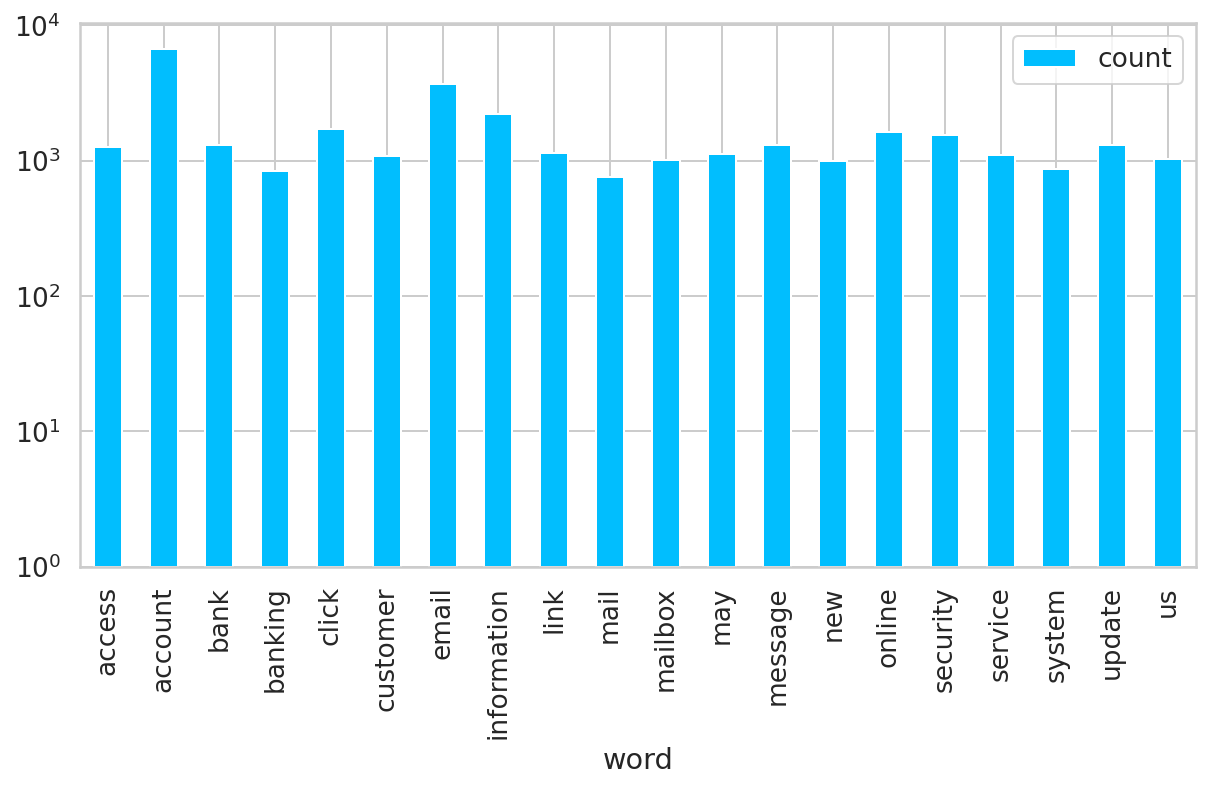

In [ ]:
# plotting frequency of words 

freq_df_phishing = pd.DataFrame({'word':asl.index, 'count':asl.values})
freq_df_phishing[:20].groupby(['word']).sum().plot(kind='bar', y='count', log = True , figsize=(10,5))

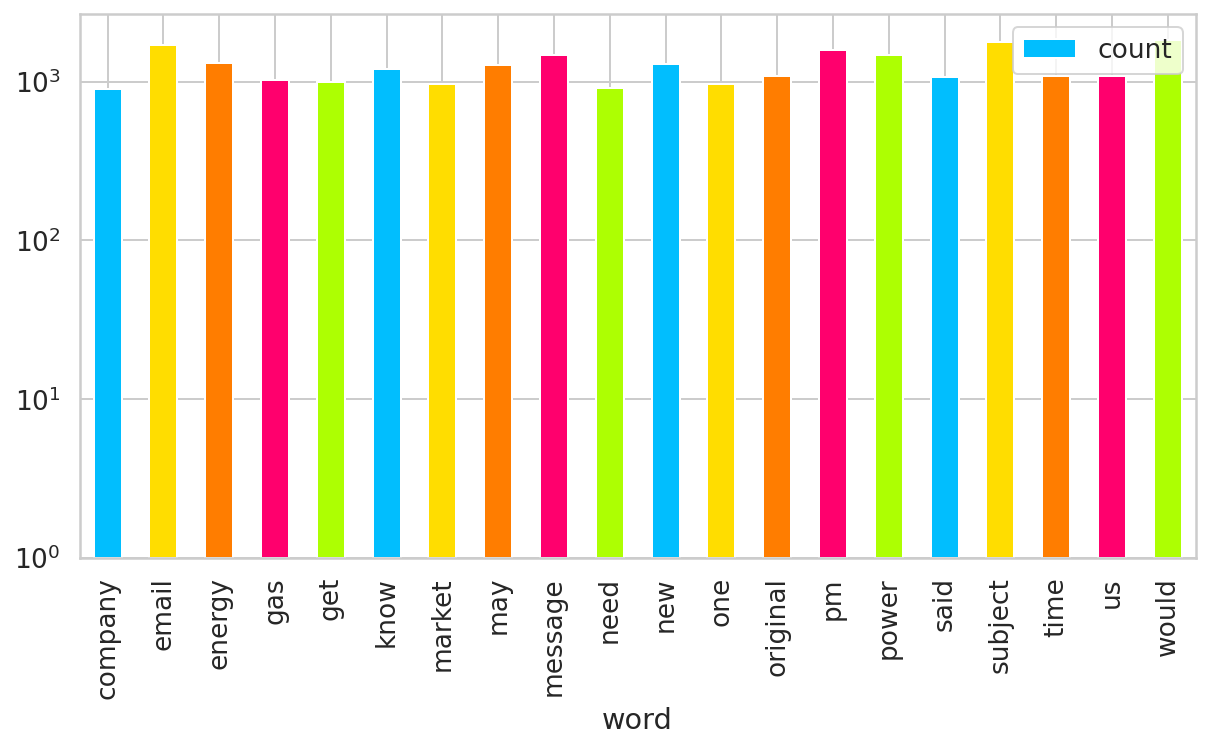

In [ ]:
freq_df_ham = pd.DataFrame({'word':word_freq_ham.index, 'count':word_freq_ham.values})
freq_df_ham[:20].groupby(['word']).sum().plot(kind='bar', y='count', log = True ,color=['C0', 'C1', 'C2', 'C3', 'C4' ], figsize=(10,5))

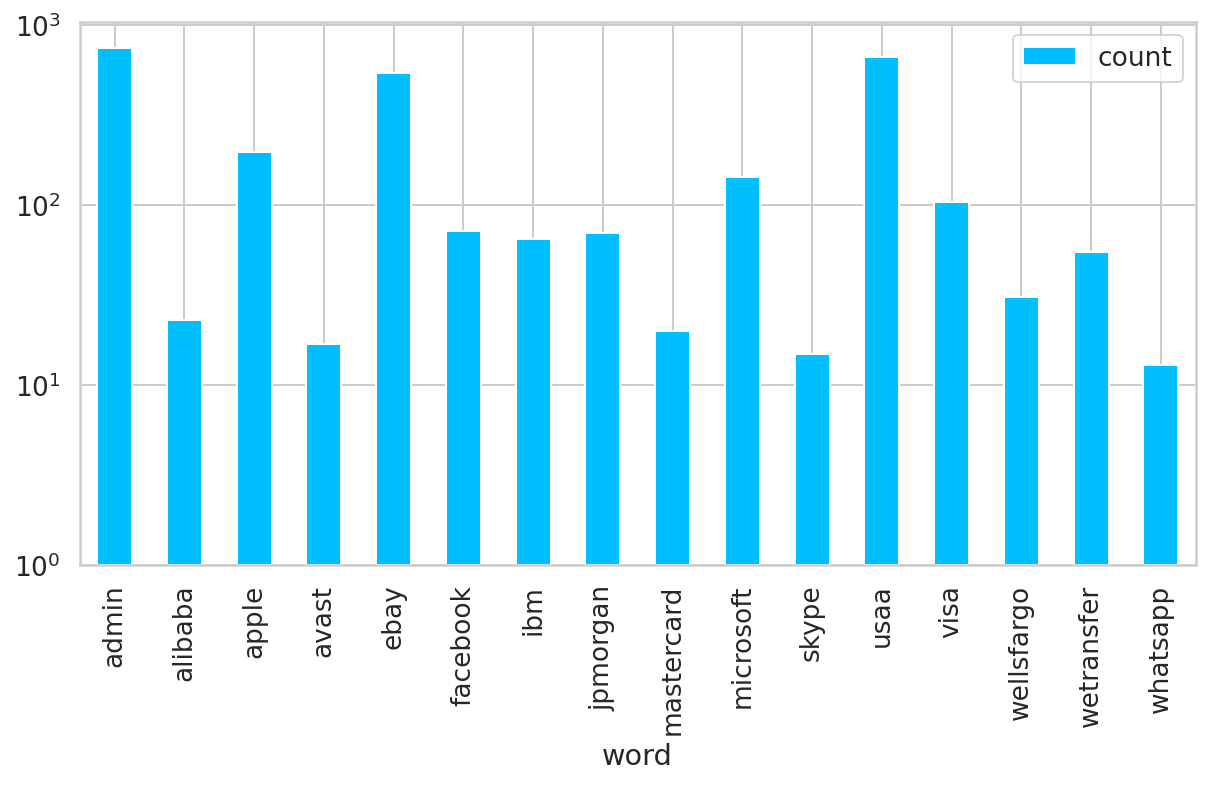

In [ ]:
auth_freq_df.groupby(['word']).sum().plot(kind='bar', y='count', log = True , figsize=(10,5))

In [ ]:
# loading false negative and false positive data
df_false_negative = pd.read_csv('/content/drive/MyDrive/thesis/emotions_model/df_false_negative.csv')
df_false_positive = pd.read_csv('/content/drive/MyDrive/thesis/emotions_model/df_false_positive.csv')

In [ ]:
# getting predictions for FN and FP for curiosity
false_negative_predictions = get_predictions_max(df_false_negative['false_negative'],tokenizer,trained_model)
false_positive_predictions = get_predictions_max(df_false_positive['false_positive'],tokenizer,trained_model)

In [ ]:
count_false_negative = pd.Series(false_negative_predictions).value_counts()
count_false_positive = pd.Series(false_positive_predictions).value_counts()


In [ ]:
# getting max scored predictions for phishing and legitimate emails
clean_phishing_label = get_predictions_max(cleaned_phishing_df['message'],tokenizer,trained_model)
clean_ham_label = get_predictions_max(cleaned_ham_df['message'],tokenizer,trained_model)

In [ ]:
# count_phishing = pd.Series(phishing_label).value_counts()
# count_ham = pd.Series(ham_label).value_counts()


# gettin value count of each label
counts_pl = pd.Series(clean_phishing_label).value_counts()
counts_chl= pd.Series(clean_ham_label).value_counts()

In [ ]:
# Ugly printing of the occurences of labels for phishing and legitimate emails


values_phishing = []
values_legitimate = []
# counts_cl = pd.Series(clean_ham_label).value_counts()
for x in LABEL_COLUMNS:
  try:
    values_phishing.append(counts_pl[x])
  except:
    values_phishing.append(0)

  try:
    values_legitimate.append(counts_chl[x])
  except:
    values_legitimate.append(0)

  try:
    print(x,'Phishing', counts_pl[x], 'Legitimate', counts_chl[x] )
  except:
    pass


admiration Phishing 33 Legitimate 105
anger Phishing 10 Legitimate 13
annoyance Phishing 85 Legitimate 18
approval Phishing 157 Legitimate 244
caring Phishing 1441 Legitimate 240
confusion Phishing 7 Legitimate 67
curiosity Phishing 76 Legitimate 809
desire Phishing 3 Legitimate 35
disappointment Phishing 38 Legitimate 47
disapproval Phishing 164 Legitimate 79
excitement Phishing 3 Legitimate 29
fear Phishing 1 Legitimate 9
gratitude Phishing 93 Legitimate 118
joy Phishing 17 Legitimate 66
love Phishing 2 Legitimate 14
optimism Phishing 64 Legitimate 276
pride Phishing 3 Legitimate 2
realization Phishing 60 Legitimate 70
remorse Phishing 250 Legitimate 62
neutral Phishing 492 Legitimate 900


In [ ]:
sample_email = "All, Please see my memo  attached, which will update you on recent developments in the NYISO technical  committees.As always, please call me if you have any  questions.    Regards,Scott"

In [ ]:
sample_email2= "Hello, your package has arrived, click on the link to track status and pick up your package with your tracking number below. Track your package 1201502149 tracking number. "

In [ ]:
# Dividing email into sentences and checking the emotion prediction on sentence level

lbls=[]
for msg in cleaned_phishing_df['message'][157].split('.'):
   my_label = get_prediction_max(msg,tokenizer,trained_model)
   lbls.append(my_label)

caring: 0.4210934638977051
neutral: 0.2619481086730957
annoyance: 0.6228486895561218
caring: 0.4912039339542389
caring: 0.6019430160522461
desire: 0.3837023079395294
neutral: 0.657975435256958


In [ ]:
# Dividing email into sentences.
cleaned_phishing_df['message'][157].split('.')

['  customer, we need your help resolving an issue with your account',
 ' thus, we have temporarily limited what you can do with your account until the issue is resolved',
 ' we understand it may be frustrating not to have full access to your account',
 ' we want to work with you to get your account back to normal as quickly as possible',
 " how can you help ? it's usually quite straight forward to take care of these things",
 ' most of the time, we just need some more information about your account or latest transactions',
 ' log in to my account yours ,']

In [ ]:
# checking the accuracy of the model
accuracy(predictions, labels, threshold=0.5)

tensor(0.9613)

In [ ]:
# Printing the AUROC per tag for the model

print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {round(float(tag_auroc),2)}")

AUROC per tag
admiration: 0.94
amusement: 0.96
anger: 0.93
annoyance: 0.86
approval: 0.79
caring: 0.93
confusion: 0.93
curiosity: 0.95
desire: 0.94
disappointment: 0.88
disapproval: 0.89
disgust: 0.93
embarrassment: 0.91
excitement: 0.91
fear: 0.97
gratitude: 0.98
grief: 0.9
joy: 0.93
love: 0.98
nervousness: 0.91
optimism: 0.91
pride: 0.87
realization: 0.82
relief: 0.85
remorse: 0.96
sadness: 0.95
surprise: 0.95
neutral: 0.78


In [ ]:
THRESHOLD = 0.5

In [ ]:
### getting predictions with threshold 0.1
phishing_th_01 = get_predictions(cleaned_phishing_df['message'], tokenizer, trained_model, 0.1)
legitimate_th_01 = get_predictions(cleaned_ham_df['message'], tokenizer, trained_model, 0.1)

count_phishing_th_01 = pd.Series(phishing_th_01).value_counts()
count_legitimate_th_01 = pd.Series(legitimate_th_01).value_counts()

In [ ]:

values_phishing_th_01 = []
values_legitimate_th_01 = []
# counts_cl = pd.Series(clean_ham_label).value_counts()
for x in LABEL_COLUMNS:
  try:
    values_phishing_th_01.append(count_phishing_th_01[x])
  except:
    values_phishing_th_01.append(0)

  try:
    values_legitimate_th_01.append(count_legitimate_th_01[x])
  except:
    values_legitimate_th_01.append(0)
    
  ''' try:
    # print(x,'Phishing', count_phishing_th_01[x], 'Legitimate', count_legitimate_th_01[x] )
  except Exception as e:
    pass '''


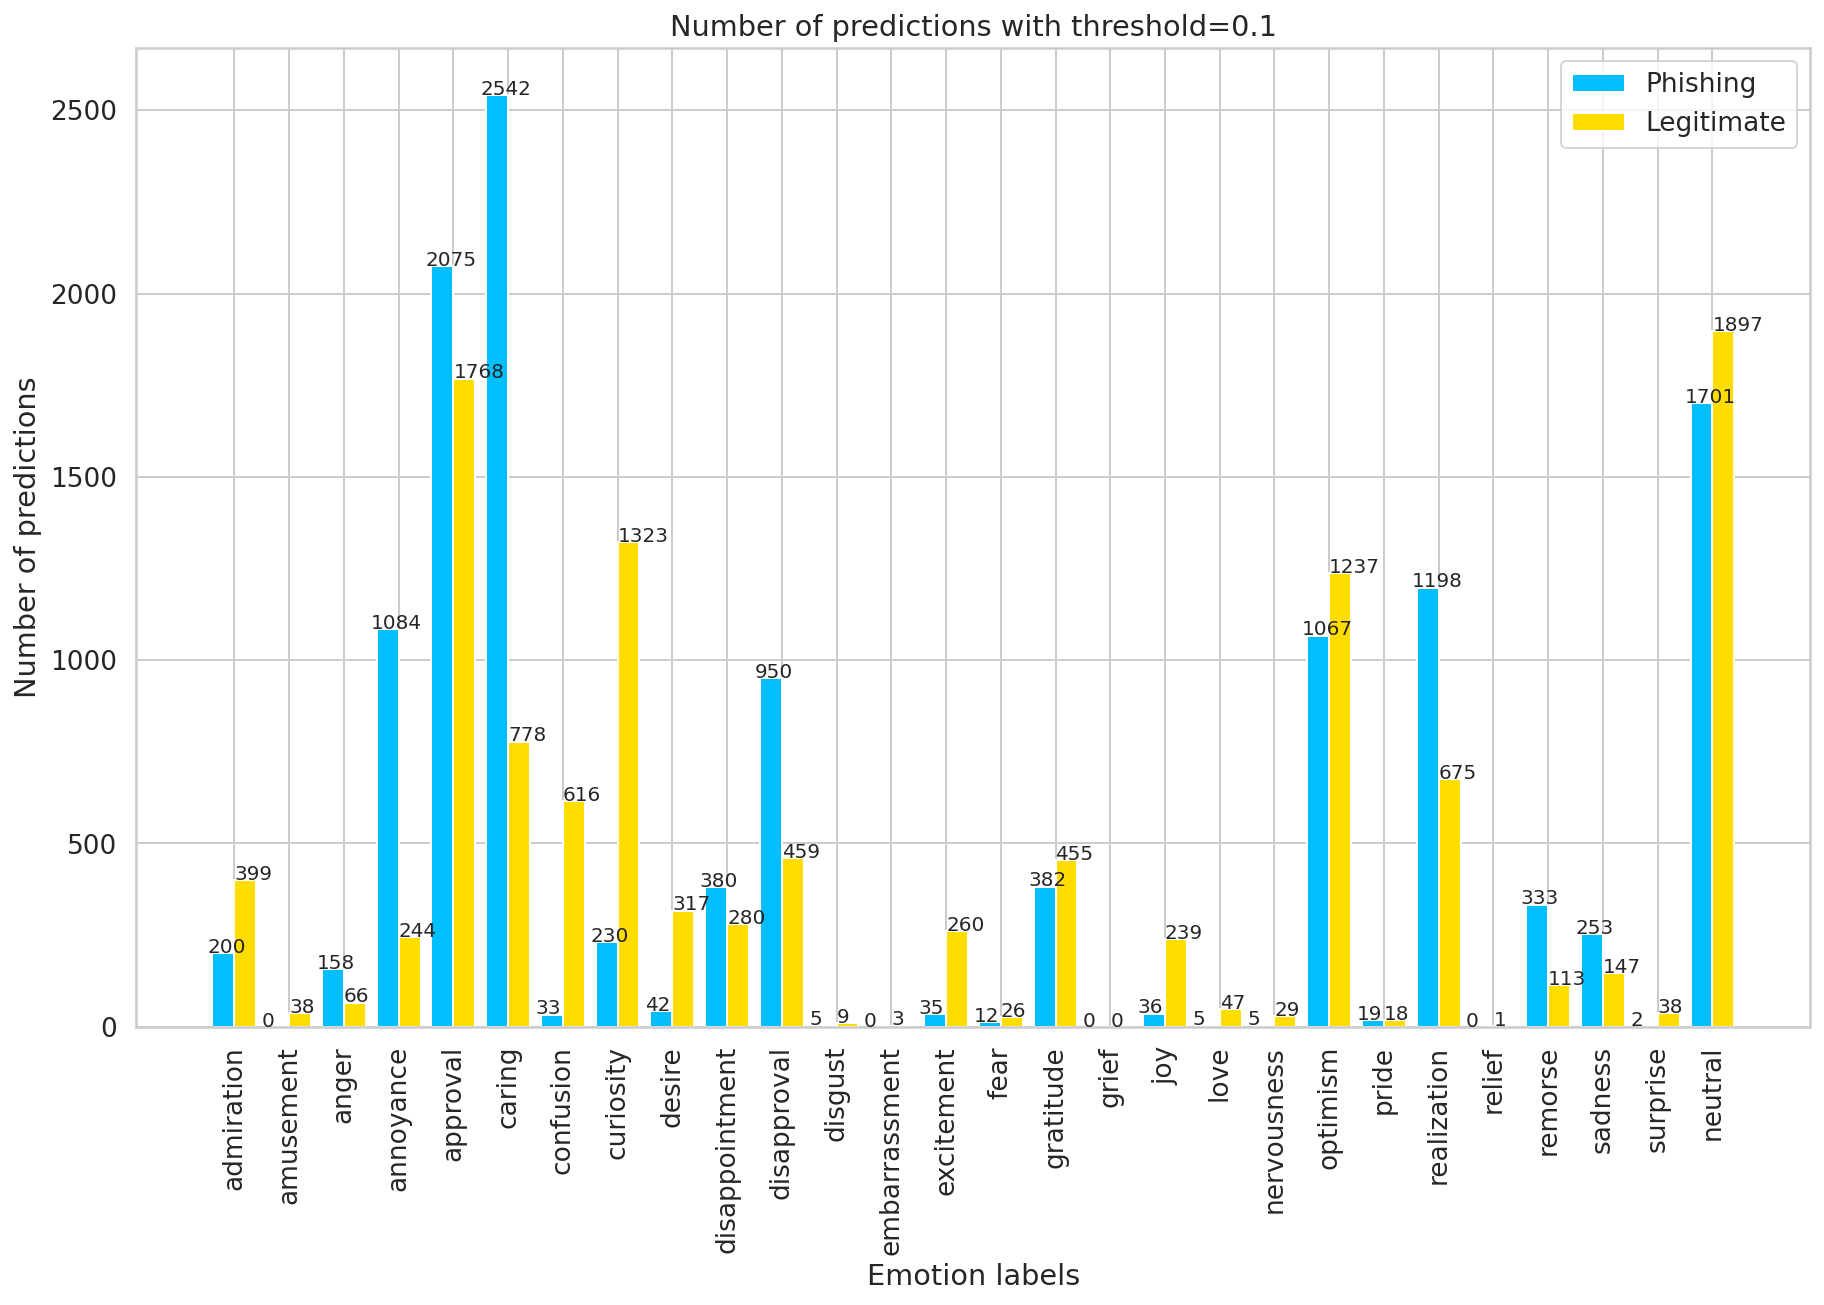

In [ ]:
# Plotting the results

X = LABEL_COLUMNS
y_phishing = values_phishing_th_01
z_legitimate = values_legitimate_th_01
  


X_axis = np.arange(len(X))

plt.figure(figsize=(15, 9))
plt.bar(X_axis - 0.2, y_phishing, 0.4, label = 'Phishing')
plt.bar(X_axis + 0.2, z_legitimate, 0.4, label = 'Legitimate')
  
plt.xticks(X_axis, X)
plt.xlabel("Emotion labels")
plt.ylabel("Number of predictions")
plt.title("Number of predictions with threshold=0.1")
for index,data in enumerate(y_phishing):
    plt.text(x=index-0.5 , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=10), rotation=0)

for index,data in enumerate(z_legitimate):
    plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=10), rotation=0)
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [ ]:
# Defining different colors for each label
import random
import matplotlib.colors as mcolors
colors = random.choices(list(mcolors.CSS4_COLORS.values()),k = 28)

In [ ]:
def make_others(mylist):
  others = 0
  new_lab_col = []
  new_val = []
  for x in mylist:
    if x < 100:
      others = others + x
    else:
      new_lab_col.append(LABEL_COLUMNS[mylist.index(x)])
      new_val.append(x)
  
  new_lab_col.append("others")
  new_val.append(others)
  return new_lab_col, new_val

In [ ]:
dnm_col, dnm_val = make_others(values_phishing_th_05)

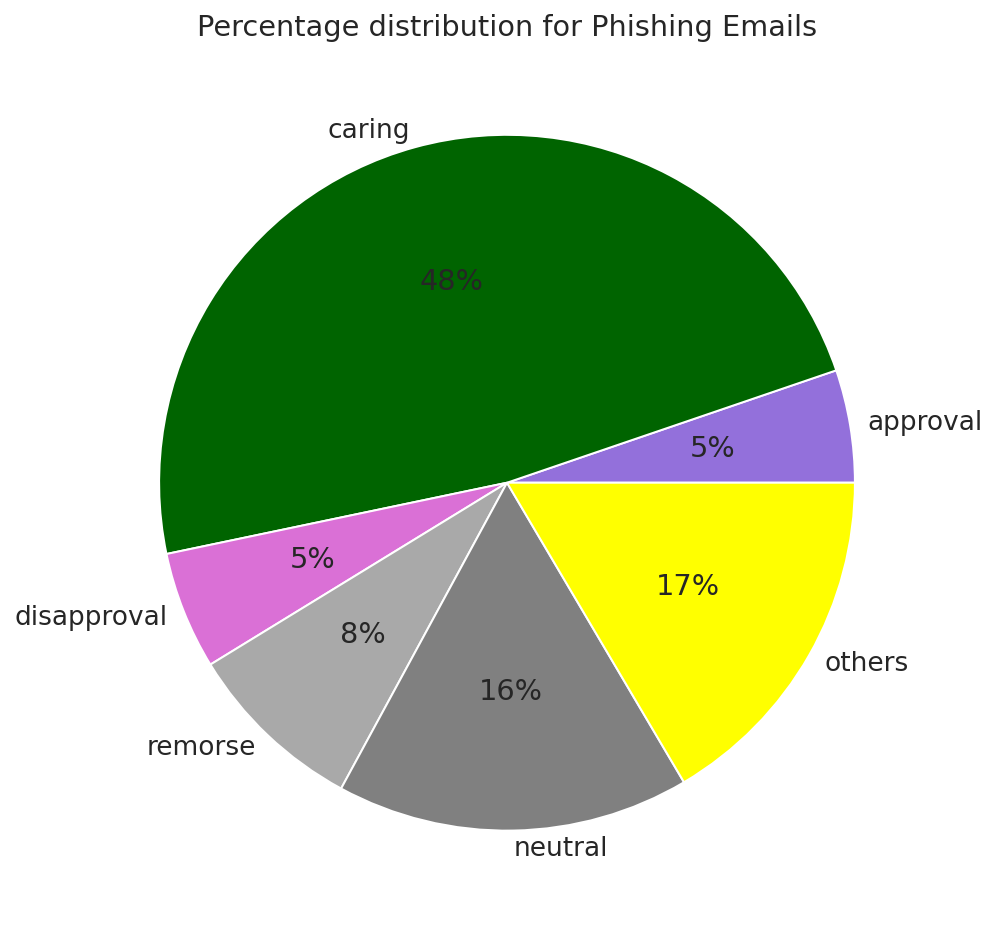

In [ ]:
plt.pie(dnm_val, labels = dnm_col, colors = colors,  autopct='%1.0f%%', labeldistance=1.05)
plt.title('Percentage distribution for Phishing Emails')
plt.show()

In [ ]:
### with threshold 0.3
phishing_th_03 = get_predictions(cleaned_phishing_df['message'], tokenizer, trained_model, 0.3)
legitimate_th_03 = get_predictions(cleaned_ham_df['message'], tokenizer, trained_model, 0.3)

count_phishing_th_03 = pd.Series(phishing_th_03).value_counts()
count_legitimate_th_03 = pd.Series(legitimate_th_03).value_counts()

In [ ]:

values_phishing_th_03 = []
values_legitimate_th_03 = []
# counts_cl = pd.Series(clean_ham_label).value_counts()
for x in LABEL_COLUMNS:
  try:
    values_phishing_th_03.append(count_phishing_th_03[x])
  except:
    values_phishing_th_03.append(0)

  try:
    values_legitimate_th_03.append(count_legitimate_th_03[x])
  except:
    values_legitimate_th_03.append(0)
    
  ''' try:
    # print(x,'Phishing', count_phishing_th_01[x], 'Legitimate', count_legitimate_th_01[x] )
  except Exception as e:
    pass '''


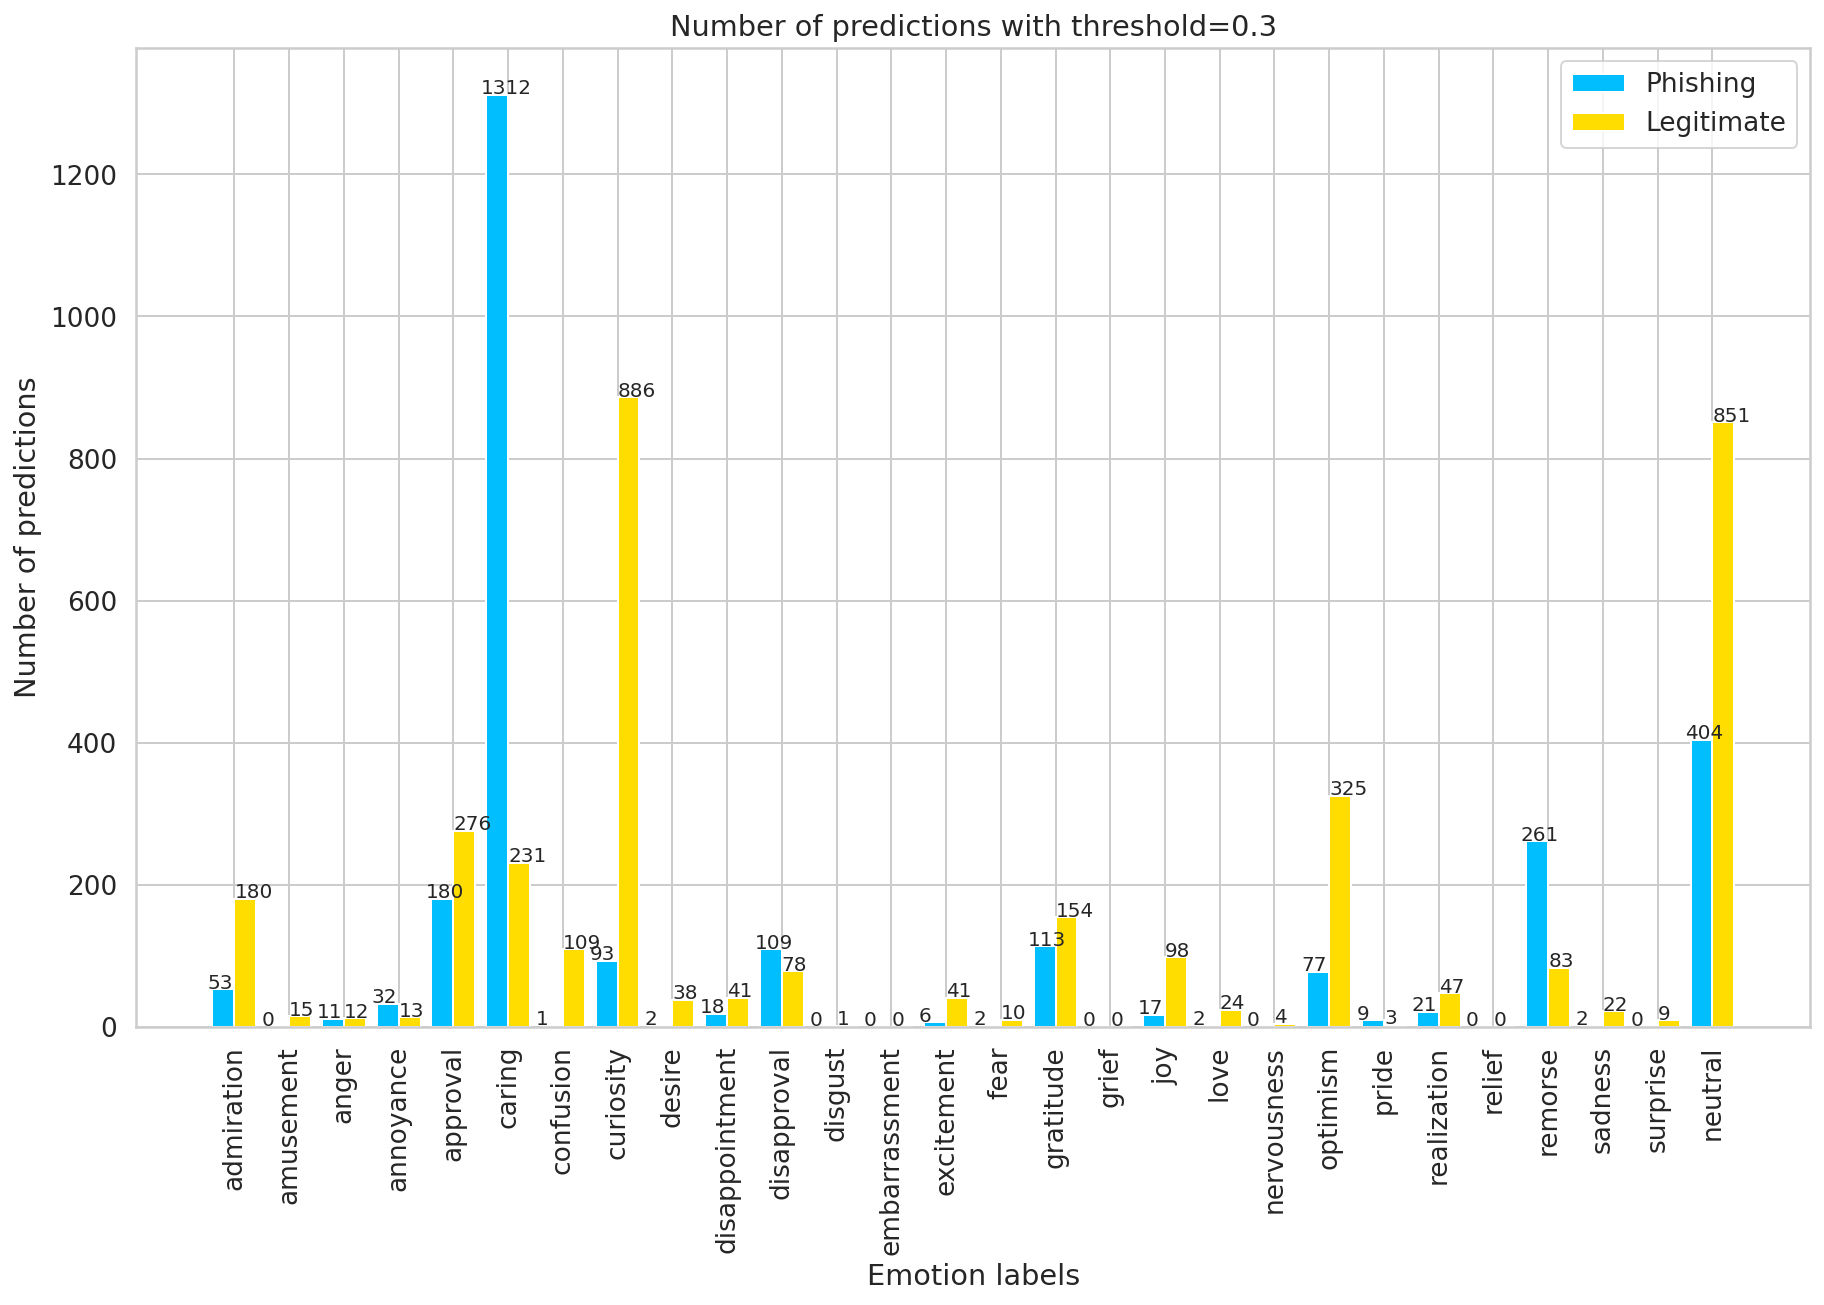

In [ ]:
# Plotting the predictions
X = LABEL_COLUMNS
y_phishing = values_phishing_th_03
z_legitimate = values_legitimate_th_03
  


X_axis = np.arange(len(X))

plt.figure(figsize=(15, 9))
plt.bar(X_axis - 0.2, y_phishing, 0.4, label = 'Phishing')
plt.bar(X_axis + 0.2, z_legitimate, 0.4, label = 'Legitimate')
  
plt.xticks(X_axis, X)
plt.xlabel("Emotion labels")
plt.ylabel("Number of predictions")
plt.title("Number of predictions with threshold=0.3")
for index,data in enumerate(y_phishing):
    plt.text(x=index-0.5 , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=10), rotation=0)

for index,data in enumerate(z_legitimate):
    plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=10), rotation=0)
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [ ]:
### Predicting the labels with threshold 0.5
phishing_th_05 = get_predictions_max(cleaned_phishing_df['message'], tokenizer, trained_model)
legitimate_th_05 = get_predictions_max(cleaned_ham_df['message'], tokenizer, trained_model)

count_phishing_th_05 = pd.Series(phishing_th_05).value_counts()
count_legitimate_th_05 = pd.Series(legitimate_th_05).value_counts()



values_phishing_th_05 = []
values_legitimate_th_05 = []
# counts_cl = pd.Series(clean_ham_label).value_counts()
for x in LABEL_COLUMNS:
  try:
    values_phishing_th_05.append(count_phishing_th_05[x])
  except:
    values_phishing_th_05.append(0)

  try:
    values_legitimate_th_05.append(count_legitimate_th_05[x])
  except:
    values_legitimate_th_05.append(0)
    
  ''' try:
    # print(x,'Phishing', count_phishing_th_01[x], 'Legitimate', count_legitimate_th_01[x] )
  except Exception as e:
    pass '''


X = LABEL_COLUMNS
y_phishing = values_phishing_th_05
z_legitimate = values_legitimate_th_05
  


X_axis = np.arange(len(X))

plt.figure(figsize=(15, 9))
plt.bar(X_axis - 0.2, y_phishing, 0.4, label = 'Phishing')
plt.bar(X_axis + 0.2, z_legitimate, 0.4, label = 'Legitimate')
  
plt.xticks(X_axis, X)
plt.xlabel("Emotion labels")
plt.ylabel("Number of predictions")
plt.title("Number of predictions with threshold=0.5")
for index,data in enumerate(y_phishing):
    plt.text(x=index-0.5 , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=10), rotation=0)

for index,data in enumerate(z_legitimate):
    plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=10), rotation=0)
plt.xticks(rotation=90)
plt.legend()
plt.show()


In [ ]:
count_false_negative

In [ ]:
values_false_positive = []
values_false_negative = []
# counts_cl = pd.Series(clean_ham_label).value_counts()
for x in LABEL_COLUMNS:
  try:
    values_false_positive.append(count_false_negative[x])
  except:
    values_false_positive.append(0)

  try:
    values_false_negative.append(count_false_positive[x])
  except:
    values_false_negative.append(0)

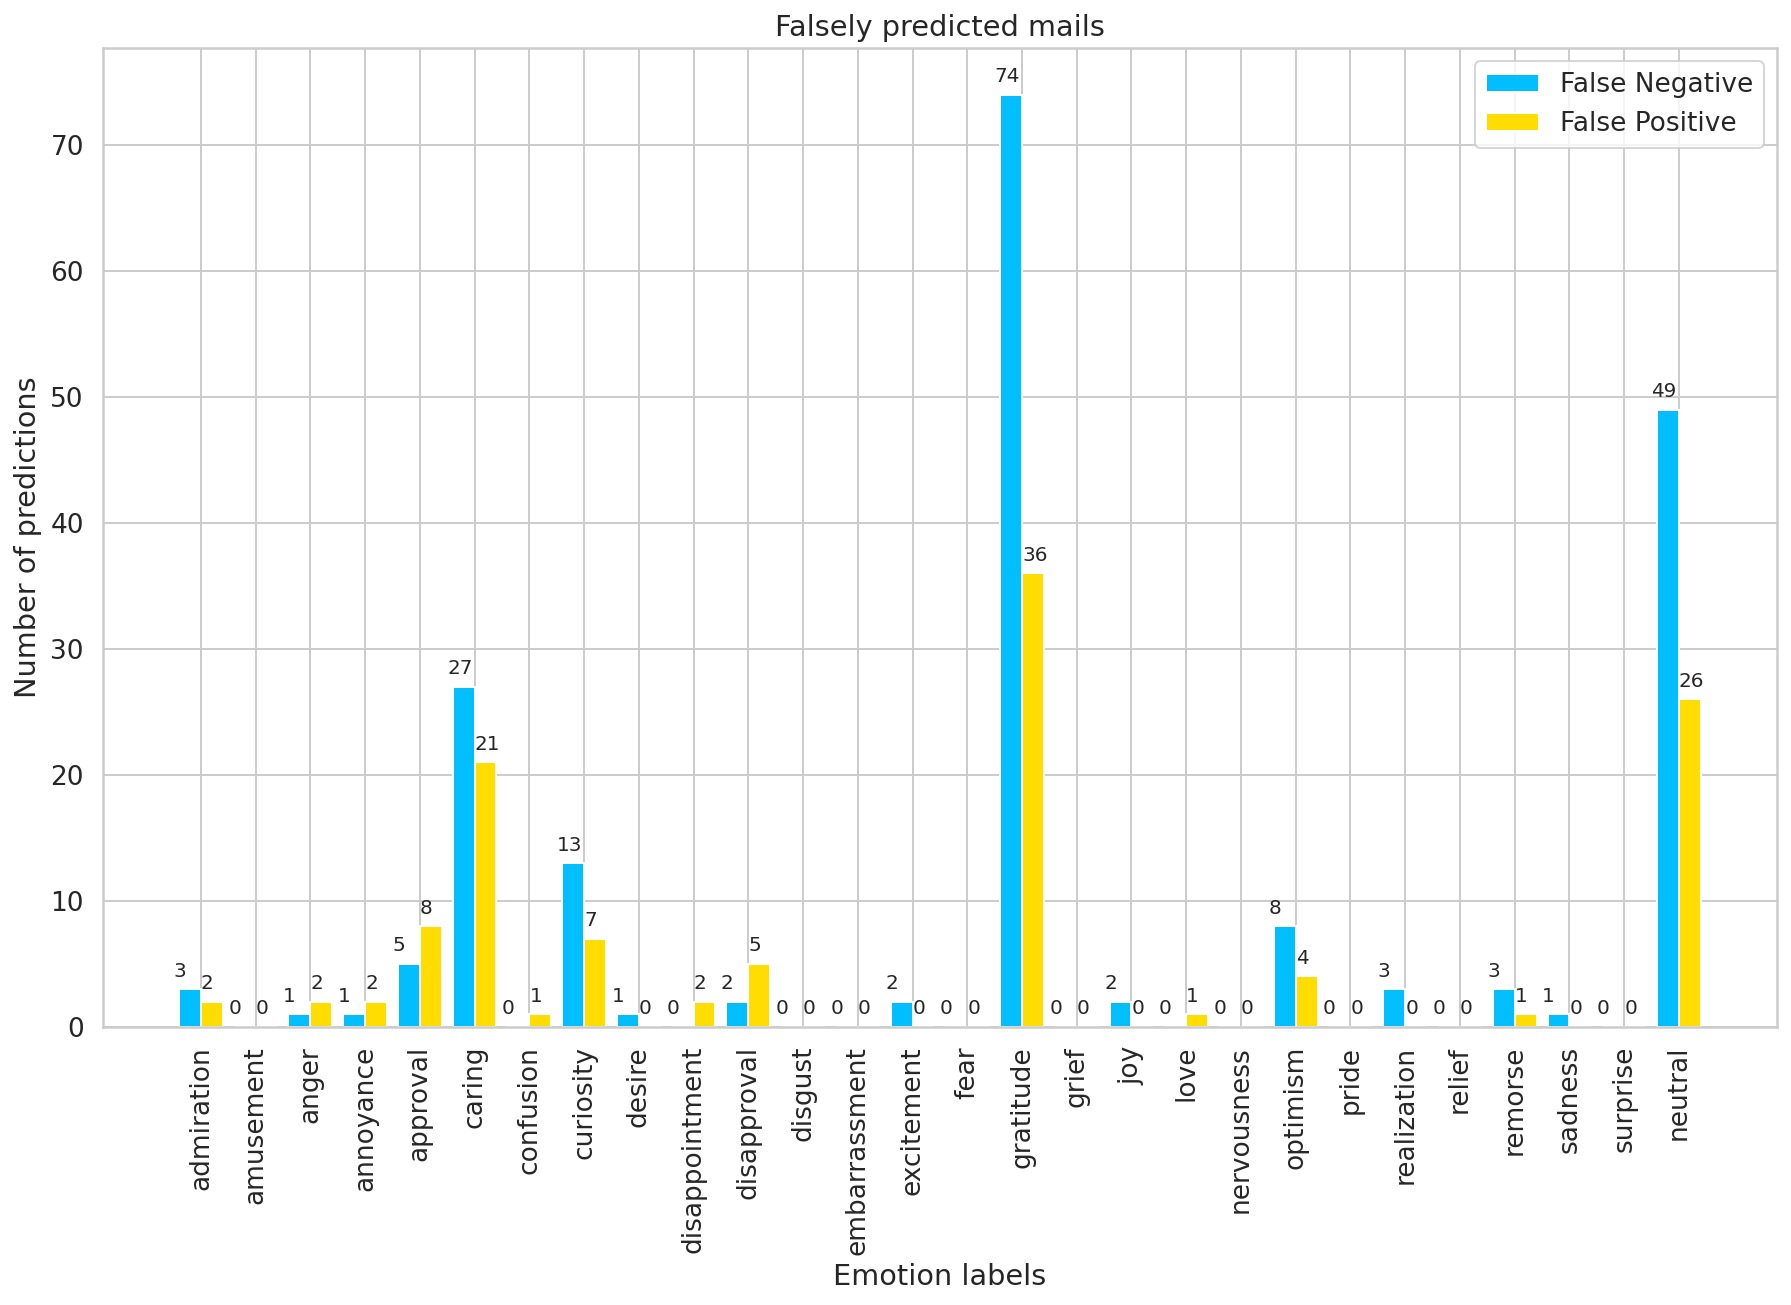

In [ ]:
# Plotting the data 

X = LABEL_COLUMNS
y_phishing = values_false_negative
z_legitimate = values_false_positive
  


X_axis = np.arange(len(X))

plt.figure(figsize=(15, 9))
plt.bar(X_axis - 0.2, y_phishing, 0.4, label = 'False Negative')
plt.bar(X_axis + 0.2, z_legitimate, 0.4, label = 'False Positive')
  
plt.xticks(X_axis, X)
plt.xlabel("Emotion labels")
plt.ylabel("Number of predictions")
plt.title("Falsely predicted mails")
for index,data in enumerate(y_phishing):
    plt.text(x=index-0.5 , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=10), rotation=0)

for index,data in enumerate(z_legitimate):
    plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=10), rotation=0)
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [ ]:
## FINALO

In [ ]:
# Functions for emotion masking operation

def make_prediction(message ,tokenizer,trained_model):
  
  main_label = []
  labels = []
  preds = []
  encoding = tokenizer.encode_plus(
      message,
      add_special_tokens=True,
      max_length=512,
      return_token_type_ids=False,
      padding="max_length",
      return_attention_mask=True,
      return_tensors='pt',
    ).to(device)
  _, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
  test_prediction = test_prediction.cpu().flatten().numpy()
  for label, prediction in zip(LABEL_COLUMNS, test_prediction):
    labels.append(label)
    preds.append(prediction)

  my_pred = max(preds)
  index = preds.index(my_pred)
  my_label = labels[index]
  print(f"{my_label}: {my_pred}")
  main_label = my_label
  return main_label, my_pred

def get_values(message ,tokenizer, trained_model):

  values = []
  sentences = message.split('.')


  if len(sentences) < 2:
    pass
  
  try:
    main_label, main_pred = make_prediction(message, tokenizer, trained_model)
    for sentence in sentences:

        label, prediction = make_prediction(sentence, tokenizer, trained_model)
        values.append([label,prediction])
    
        
  except Exception as e:
    print('Error  ', e )
    pass

  return values, main_label

def mask_sentence(message ,tokenizer, trained_model):
  try:
    values, main_label = get_values(message, tokenizer, trained_model)
    my_index = 0
    my_score = 0
    for val in values:
      if val[0] == main_label and val[1] > my_score:
        my_index = values.index(val)
        my_score = val[1]

    seperated = message.split('.')
    masked_list = seperated[:my_index] + seperated[my_index+1 :]
    masked = '.'.join(masked_list)

  except Exception as e:
    print('Error', e)

  return masked
    


In [ ]:
cc =0
encoding = tokenizer.encode_plus(
  masked,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
).to(device)
_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.cpu().flatten().numpy()
for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  if prediction < 0.1:
    continue
  print(f"{label}: {round(float(prediction),2)}")
  cc = cc + prediction

In [ ]:
masked = mask_sentence(cleaned_phishing_df['message'][27] ,tokenizer, trained_model)


In [ ]:
mm = []
for i, r in cleaned_ham_df.iterrows():
  try:
    masked = mask_sentence(r['message'], tokenizer, trained_model)
    mm.append(masked)
  except Exception as e:
    print('ErrorL:', e)
    pass

In [ ]:
masked_phishing_df = pd.DataFrame(mm, columns = ['message'])

In [ ]:
masked_phishing_df.to_csv("/content/drive/My Drive/thesis/masked_ham_df.csv")